In [2]:
nEpochs=20  # orig, longer training
#nEpochs=3  # quick testing during development

# Select one (and only one) model to train
USE_CGAN = False
USE_CVAE = True
USE_CVAECGAN = False

# Extract model name based on boolean value above
model_name = ""
if USE_CGAN:
    model_name += "cgan"
elif USE_CVAE:
    model_name += "cvae"
elif USE_CVAECGAN:
    model_name += "cvaecgan"

# Double check model name is valid
#if model_name not in {"cgan", "cvae", "cvaecgan"}:
#    raise Exception("Double check you are only using one model. The current model name is invalid")

%cd ./HPO/

/project/nanocourse/SWE_OOP/train08/repos/Module_2_ArmandRathgeb/HPO


## 1. Import 3rd party libraries 

In [3]:
import os
import session_info
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[0], 
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    #)
except:
    Warning("Unable To configure Tensorflow GPU")
    
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN

#session_info.show()

2025-05-30 13:35:06.846198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748630106.868994   17097 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748630106.876100   17097 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748630106.893821   17097 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748630106.893838   17097 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748630106.893840   17097 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 3. Show some our data

I0000 00:00:1748630114.019064   17097 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15494 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
I0000 00:00:1748630114.019613   17097 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15506 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


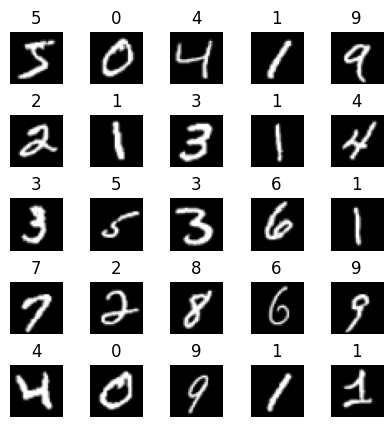

In [4]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist' + f"_hpo_{model_name}"
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

test_labels_onehot = tf.one_hot(data.labels_test,
                                depth=n_classes,
                                dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [5]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
hpo_params = {
    'n_latent_dims' : 4,
    'learning_rate': 0.001,
    'encoder_params' : {
        'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4,4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [4,4],
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'generator_params' : {
        'generator_conv_layer_units' : [128,128],
        'generator_conv_layer_kernel_size' : [4,4],
        'generator_conv_layer_strides' : [(2,2), (2,2)],
        'generator_conv_layer_activation_functions' : [tf.nn.leaky_relu,tf.nn.leaky_relu],
        'discriminator_dense_layer_units' : [128],
        'generator_dense_layer_units' : [],
    },
    'discriminator_params' : {
        'discriminator_conv_layer_units' : [32,64],
        'discriminator_conv_layer_kernel_size' : [4,4],
        'discriminator_conv_layer_strides' : [(1,1), (2,2)],
        'discriminator_conv_layer_activation_functions' : ['relu','relu'],
        'discriminator_dense_layer_units' : [],
        'generator_dense_layer_units' : [],
    }
}

if USE_CGAN:
    model = ConditionalGAN(n_classes=n_classes,
                                 n_latent_dims = hpo_params['n_latent_dims'],
                                 generator_params = hpo_params['generator_params'],
                                 discriminator_params = hpo_params['discriminator_params'])
if USE_CVAE:
    model = ConditionalVAE(n_classes=n_classes, 
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params = hpo_params['encoder_params'],
                            decoder_params = hpo_params['decoder_params'],
    )
if USE_CVAECGAN:
    hpo_params['n_latent_dims'] = 128
    model = ConditionalVAECGAN(adv_loss_weight=10., 
                            n_classes=n_classes,
                            n_latent_dims = hpo_params['n_latent_dims'],
                            encoder_params=hpo_params['encoder_params'],
                            decoder_params=hpo_params['decoder_params'],
                            discriminator_params=hpo_params['discriminator_params']
    )


# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.

# All three models will use this input structure
#model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
#if USE_CVAE or USE_CVAECGAN:
#    model.decoder.compute_output_shape((None, n_classes + model.n_latent_dims))
#if USE_CGAN or USE_CVAECGAN:
#    model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS


In [6]:
print("=== OVERALL MODEL ====")
model.summary()

if USE_CGAN:
    print("=== GENERATOR SUBMODEL ====")
    gen_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,))
    gen_out  = model.generator.call(gen_in) 
    gen = tf.keras.Model(gen_in, gen_out) 
    gen.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(tf.TensorShape(model.image_shape,)) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()
if USE_CVAE:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
if USE_CVAECGAN:
    print("=== ENCODER SUBMODEL ====")
    enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
    enc_out  = model.encoder.call(enc_in) 
    enc = tf.keras.Model(enc_in, enc_out) 
    enc.summary()
    print("=== DECODER SUBMODEL ====")
    dec_in = tf.keras.layers.Input((model.n_latent_dims + model.n_classes,)) 
    dec_out  = model.decoder.call(dec_in) 
    dec = tf.keras.Model(dec_in, dec_out) 
    dec.summary()
    print("=== DISCRIMINATOR SUBMODEL ====")
    disc_in = tf.keras.layers.Input(tf.TensorShape(model.image_shape,)) 
    disc_out  = model.discriminator.call(disc_in) 
    disc = tf.keras.Model(disc_in, disc_out) 
    disc.summary()


=== OVERALL MODEL ====


Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

=== ENCODER SUBMODEL ====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 32, 32,    │      2,832 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │         64 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │     16,448 │ relu0[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 16, 16,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 16, 16,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense0 (Dense)      │ (None, 128)       │  2,097,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_mean (Dense)  │ (None, 4)         │        516 │ dense0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_logvar        │ (None, 4)         │        516 │ dense0[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,117,912 (8.08 MB)

 Trainable params: 2,117,752 (8.08 MB)

 Non-trainable params: 160 (640.00 B)

=== DECODER SUBMODEL ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_to_conv (Dense)           │ (None, 16384)          │       245,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv1 (Conv2DTranspose)        │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tconv0 (Conv2DTranspose)        │ (None, 32, 32, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 32, 32, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (Activation)              │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_out (Conv2D)               │ (None, 32, 32, 1)      │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_out (Activation)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,097 (1.25 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 160 (640.00 B)

In [7]:
_ = model([data.images_train[:1], labels_onehot[:1]])

I0000 00:00:1748630135.160381   17097 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 6. Compile the model 

In [8]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
if USE_CGAN:
    save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                    model=model,
                                                    example_labels=labels_onehot[:10],
                                                    n_generated_images=10,
                                                    n_latent_dims=model.n_latent_dims)
elif USE_CVAE or USE_CVAECGAN:
    save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)



## 7. Train (fit) the model on the data 

In [9]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/20


I0000 00:00:1748630144.145798   24635 service.cc:152] XLA service 0x2aaeb00027d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748630144.146526   24635 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748630144.146548   24635 service.cc:160]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0


 12/469 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - kl_loss: 1004.1617 - recon_loss: 267.1594 - total_loss: 1271.3210

I0000 00:00:1748630149.105431   24635 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - kl_loss: 122.4521 - recon_loss: 91.1678 - total_loss: 213.6198
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 6.8615 - recon_loss: 34.5200 - total_loss: 41.3814
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 6.2153 - recon_loss: 29.6294 - total_loss: 35.8447
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.9581 - recon_loss: 27.2081 - total_loss: 33.1662
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.8989 - recon_loss: 25.5518 - total_loss: 31.4508
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 5.9278 - recon_loss: 24.8964 - total_loss: 30.8242
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.9162 - recon_loss: 24.3532 - total_loss: 30.2694
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 5.9643 - recon_loss: 24.0888 - total_loss: 30.0531
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.9727 - recon_loss: 23

## 8. Training saves results to disk, now also plot training curves

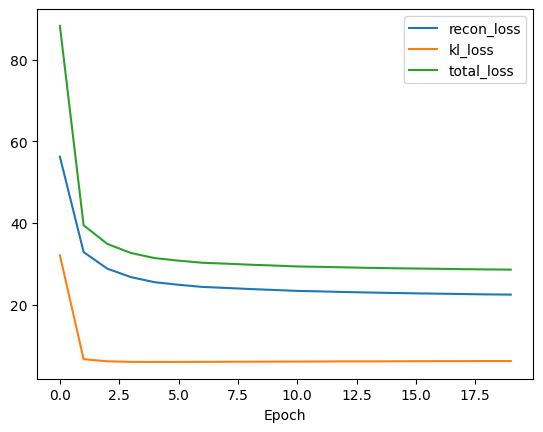

In [10]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['enc_loss', 'dec_loss', 'disc_loss', 'gen_loss', 'recon_loss', 'kl_loss', 'total_loss']:
    if loss_name in logs.history.keys():
        loss_values = logs.history[loss_name]
        x = np.arange(len(loss_values))
        ax.plot(x, loss_values, label=loss_name)
        
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
fig.show()

# Save the model 
model.save(os.path.join(output_dir, model_name+".keras"))


# HPO Exercise: Your Turn!
- Take the code from above, and implement a grid search over at least 2 hyper parameters (try at least 3 different values for each hyper parameter)
  - Train each model for at least 20 epochs. 
  - You can modify both hyperparameters at the same time, or perform two completely separate sequential tunings. 
  - You can find some suggested hyperparameter ranges / values in the table below:

Hyperparameter | [min value, max value]
----------------|-----------------------
Number of latent dims: |   [2, 128]
Number of Convolutional layers: |     [1, 6]
Number of convolutional layer units:|     [4, 256]
Convolutional kernel size: | [2, 5]
Convolutional layer activation functions (choose): |  ['relu', 'elu', 'linear', tf.nn.leaky_relu, 'softmax', 'sigmoid']
Dense layer units: | [4, 256]
Learning Rate:  | [0.01, 0.000001]


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - class_loss: 0.4375 - dec_loss: 90.1620 - disc_loss: 0.4611 - enc_loss: 180.2484 - kl_loss: 90.6754 - recon_loss: 89.5729 - top_1_acc: 0.8850
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0607 - dec_loss: 25.4148 - disc_loss: 0.0609 - enc_loss: 37.8142 - kl_loss: 12.4455 - recon_loss: 25.3687 - top_1_acc: 0.9819
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - class_loss: 0.0398 - dec_loss: 20.7857 - disc_loss: 0.0400 - enc_loss: 32.3091 - kl_loss: 11.5568 - recon_loss: 20.7523 - top_1_acc: 0.9878
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - class_loss: 0.0271 - dec_loss: 18.9255 - disc_loss: 0.0274 - enc_loss: 30.1390 - kl_loss: 11.2374 - recon_loss: 18.9016 - top_1_acc: 0.9915
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0186 - dec_loss: 17.8209 - disc_loss: 0.0191 - enc_loss: 28.7904 - kl_loss: 10.9853 - recon_loss: 17.8050 - top_1_acc: 0.9940
Epoch 6/20
469/469 

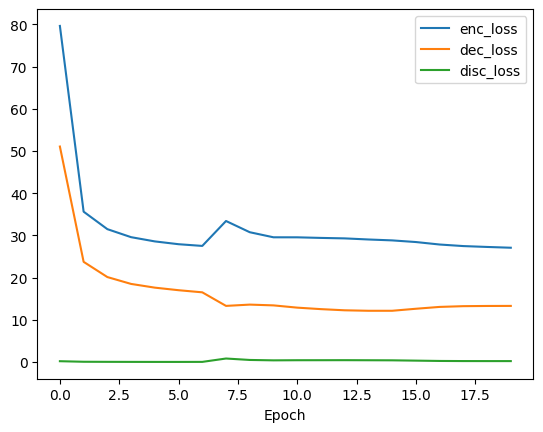

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - recon_loss: 15.9782
Learning rate: 0.001 === Latent dims: 32 === Reconstruction loss: 15.730741500854492
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - class_loss: 0.4561 - dec_loss: 63.9895 - disc_loss: 0.4778 - enc_loss: 173.8423 - kl_loss: 110.4937 - recon_loss: 63.3486 - top_1_acc: 0.8879
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - class_loss: 0.0590 - dec_loss: 25.2124 - disc_loss: 0.0594 - enc_loss: 37.8355 - kl_loss: 12.6726 - recon_loss: 25.1628 - top_1_acc: 0.9819
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0377 - dec_loss: 20.9791 - disc_loss: 0.0382 - enc_loss: 32.5793 - kl_loss: 11.6410 - recon_loss: 20.9383 - top_1_acc: 0.9877
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0306 - dec_loss: 19.1328 - disc_loss: 0.0312 - enc_loss: 30.4098 - kl_loss: 11.3095 - recon_loss: 19.1003 - top_1_acc: 0.9902
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss:

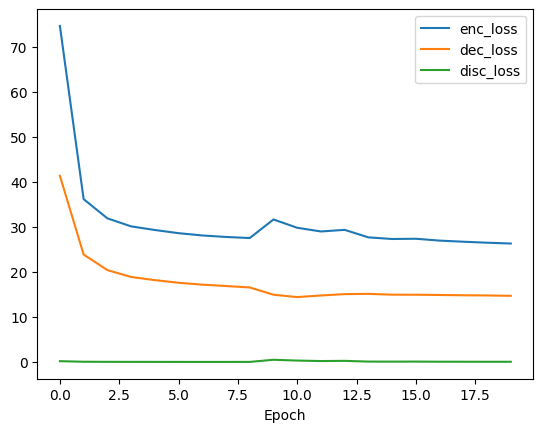

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - recon_loss: 15.0378
Learning rate: 0.001 === Latent dims: 64 === Reconstruction loss: 14.784276008605957
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - class_loss: 0.4350 - dec_loss: 114.9776 - disc_loss: 0.4550 - enc_loss: 218.4625 - kl_loss: 104.7430 - recon_loss: 113.7196 - top_1_acc: 0.8872
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0557 - dec_loss: 28.6114 - disc_loss: 0.0559 - enc_loss: 40.3872 - kl_loss: 11.8241 - recon_loss: 28.5631 - top_1_acc: 0.9829
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0358 - dec_loss: 23.4752 - disc_loss: 0.0360 - enc_loss: 34.2936 - kl_loss: 10.8532 - recon_loss: 23.4405 - top_1_acc: 0.9887
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0249 - dec_loss: 21.5972 - disc_loss: 0.0261 - enc_loss: 32.0553 - kl_loss: 10.4817 - recon_loss: 21.5736 - top_1_acc: 0.9923
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - class_los

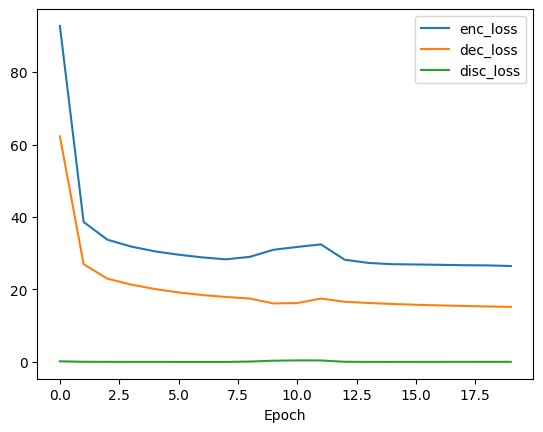

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - recon_loss: 15.9195
Learning rate: 0.001 === Latent dims: 128 === Reconstruction loss: 15.734030723571777
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - class_loss: 0.3851 - dec_loss: 92.1975 - disc_loss: 0.4043 - enc_loss: 206.6780 - kl_loss: 115.4312 - recon_loss: 91.2468 - top_1_acc: 0.8924
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0584 - dec_loss: 30.4603 - disc_loss: 0.0586 - enc_loss: 42.1262 - kl_loss: 11.7432 - recon_loss: 30.3830 - top_1_acc: 0.9814
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0349 - dec_loss: 26.8503 - disc_loss: 0.0351 - enc_loss: 37.9951 - kl_loss: 11.1896 - recon_loss: 26.8054 - top_1_acc: 0.9884
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - class_loss: 0.0250 - dec_loss: 24.6991 - disc_loss: 0.0253 - enc_loss: 35.8918 - kl_loss: 11.2298 - recon_loss: 24.6619 - top_1_acc: 0.9919
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss

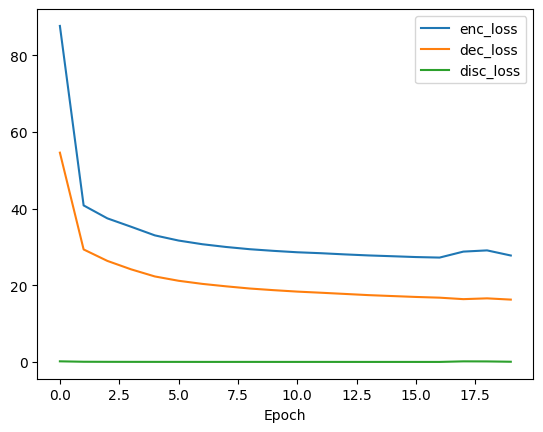

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - recon_loss: 16.1894
Learning rate: 0.001 === Latent dims: 256 === Reconstruction loss: 16.072141647338867
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - class_loss: 0.5746 - dec_loss: 105.5130 - disc_loss: 0.6203 - enc_loss: 113.7118 - kl_loss: 8.9148 - recon_loss: 104.7970 - top_1_acc: 0.8196
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0772 - dec_loss: 37.9875 - disc_loss: 0.0779 - enc_loss: 47.7589 - kl_loss: 9.9620 - recon_loss: 37.7969 - top_1_acc: 0.9778
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0500 - dec_loss: 28.6275 - disc_loss: 0.0505 - enc_loss: 38.8319 - kl_loss: 10.3245 - recon_loss: 28.5073 - top_1_acc: 0.9864
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - class_loss: 0.0369 - dec_loss: 24.4380 - disc_loss: 0.0372 - enc_loss: 34.9643 - kl_loss: 10.6125 - recon_loss: 24.3517 - top_1_acc: 0.9903
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss:

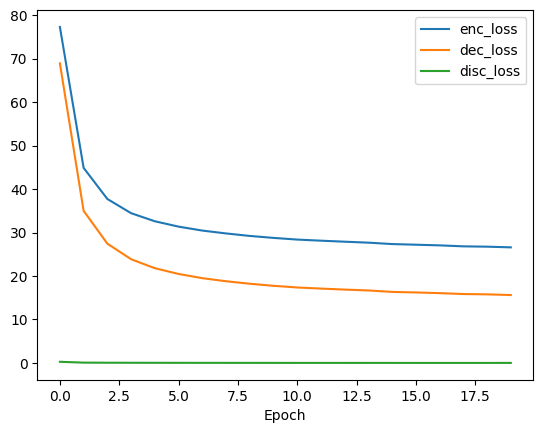

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - recon_loss: 15.3239
Learning rate: 0.0001 === Latent dims: 32 === Reconstruction loss: 15.095800399780273
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - class_loss: 0.5145 - dec_loss: 111.6783 - disc_loss: 0.5927 - enc_loss: 119.6787 - kl_loss: 8.4845 - recon_loss: 111.1942 - top_1_acc: 0.8382
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0741 - dec_loss: 43.8406 - disc_loss: 0.0749 - enc_loss: 52.5563 - kl_loss: 8.8914 - recon_loss: 43.6649 - top_1_acc: 0.9785
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0489 - dec_loss: 32.8878 - disc_loss: 0.0493 - enc_loss: 42.5616 - kl_loss: 9.7858 - recon_loss: 32.7758 - top_1_acc: 0.9861
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0368 - dec_loss: 27.4487 - disc_loss: 0.0371 - enc_loss: 37.6054 - kl_loss: 10.2440 - recon_loss: 27.3614 - top_1_acc: 0.9898
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - class_loss: 

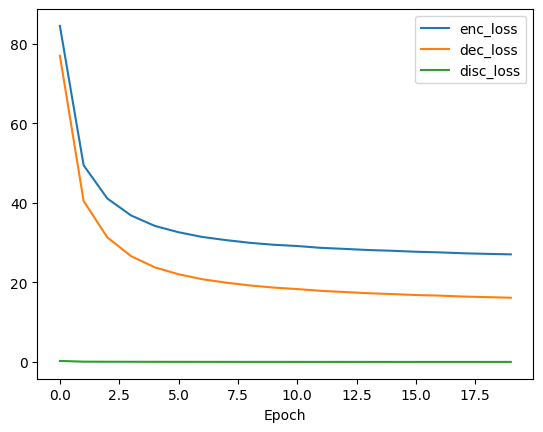

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - recon_loss: 15.9770
Learning rate: 0.0001 === Latent dims: 64 === Reconstruction loss: 15.746850967407227
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - class_loss: 0.4940 - dec_loss: 121.3316 - disc_loss: 0.5344 - enc_loss: 131.5306 - kl_loss: 11.1476 - recon_loss: 120.3830 - top_1_acc: 0.8433
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0675 - dec_loss: 48.4235 - disc_loss: 0.0681 - enc_loss: 56.7744 - kl_loss: 8.5877 - recon_loss: 48.1867 - top_1_acc: 0.9799
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - class_loss: 0.0445 - dec_loss: 37.3904 - disc_loss: 0.0449 - enc_loss: 46.5794 - kl_loss: 9.3253 - recon_loss: 37.2541 - top_1_acc: 0.9874
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 0.0323 - dec_loss: 31.7239 - disc_loss: 0.0326 - enc_loss: 41.3966 - kl_loss: 9.7665 - recon_loss: 31.6302 - top_1_acc: 0.9912
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - class_loss: 

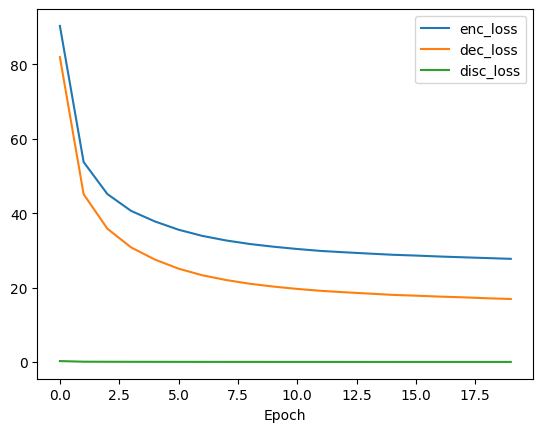

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - recon_loss: 16.7483
Learning rate: 0.0001 === Latent dims: 128 === Reconstruction loss: 16.473613739013672
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - class_loss: 0.5378 - dec_loss: 99.7914 - disc_loss: 0.5705 - enc_loss: 110.4270 - kl_loss: 11.7418 - recon_loss: 98.6852 - top_1_acc: 0.8307
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - class_loss: 0.0729 - dec_loss: 41.9162 - disc_loss: 0.0735 - enc_loss: 50.3909 - kl_loss: 8.7311 - recon_loss: 41.6598 - top_1_acc: 0.9784
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - class_loss: 0.0464 - dec_loss: 35.1455 - disc_loss: 0.0467 - enc_loss: 44.0526 - kl_loss: 9.0666 - recon_loss: 34.9860 - top_1_acc: 0.9873
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - class_loss: 0.0343 - dec_loss: 31.5243 - disc_loss: 0.0346 - enc_loss: 40.8492 - kl_loss: 9.4424 - recon_loss: 31.4068 - top_1_acc: 0.9912
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - class_loss: 0

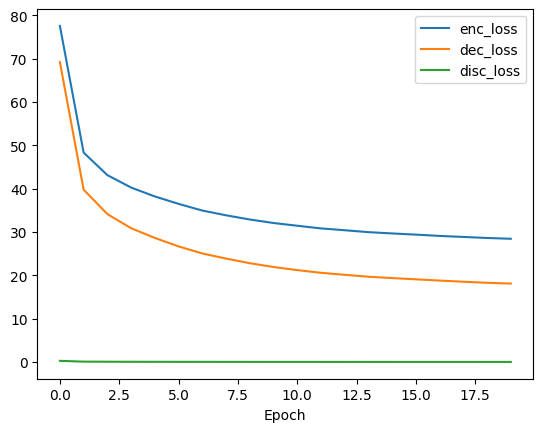

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - recon_loss: 17.5979
Learning rate: 0.0001 === Latent dims: 256 === Reconstruction loss: 17.267656326293945


In [21]:
## !!!!IMPORTANT!!!!
## Keep the seed the same across ALL HPO experiments. Be sure to reinitialize for EVERY new model.
## !!!!IMPORTANT!!!!
# Instantiate a container with the hyperparameter(s) you want to test
# Instantiate a model for a hyperparameter (combination)
## Note: I would recommend naming your model with the specific HPO you are trying at the moment.

# Build a model with input / output dimensions

# Compile the model

# Fit model to the data

# Plot the training curves for the model

# Save the model 

# Assuming you are using the provided callbacks and save the model/outputs appropriately,
# You should be able to use the provided `image_viewer` to look at the fakes and/or recons just by
# Passing in a model's name/directory.

def save_plot(logs, losses, output_dir, training):
    """Plot the training curve for a model and save it
    Parameters:
    -----------
    logs : tf.keras.callbacks.History|tf.Tensor
        Value to plot in the logs
    losses : list[str]
        List of losses to extract from `logs`
    output_dir : str
        Location where the figure should be saved
    training : str
        What should the figure be titled? "training" or "testing"
    """
    fig,ax = plt.subplots()
    for l in losses:
        if type(logs) is tf.keras.callbacks.History:
            loss_v = logs.history[l]
        else:
            loss_v = logs
        x = np.arange(len(loss_v))
        ax.plot(x, loss_v, label=l)
    ax.legend()
    ax.set_xlabel('Epoch')
    fig.savefig(os.path.join(output_dir, training + '_curves.png'), transparent=False)
    #fig.show()
    plt.show()
 

test_onehot = tf.one_hot(data.labels_test,
                        depth=n_classes,
                        dtype=tf.float32).numpy()

# Initialize the current minimum loss value
# Current loss value, index
min_loss = (np.inf, -1)

# Perfor grid search over learning rate and n_latent_dims
for lr in range(3, 5):
    learning_rate = 10**(-lr)
    hpo_params['learning_rate'] = learning_rate
    for ld in [32,64,128,256]:
        hpo_params['n_latent_dims'] = ld
        output_dir = './outputs/mnist_hpo_cvae_' + str(learning_rate) + '_' + str(ld)
        os.makedirs(output_dir, exist_ok=True)
        tf.random.set_seed(1234)

        # Build the model
        model = ConditionalVAECGAN(
            adv_loss_weight=10,
            n_classes=n_classes,
            n_latent_dims=hpo_params['n_latent_dims'],
            encoder_params=hpo_params['encoder_params'],
            decoder_params=hpo_params['decoder_params'],
            discriminator_params=hpo_params['discriminator_params']
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate'])
        )
        callback = SaveImagesConditional(
            output_dir=output_dir,
            model=model,
            example_images=data.images_train[:10],
            example_labels=labels_onehot[:10],
            n_generated_images=10,
            n_latent_dims=model.n_latent_dims
        )
        logs=model.fit([data.images_train, labels_onehot],
            batch_size=128,
            epochs=20,
            callbacks=[callback]
        )
        save_plot(logs, ['enc_loss', 'dec_loss', 'disc_loss'], output_dir, "training")
       

        # Evaluate performance. Returns the mean reconstruction error.
        logs=model.evaluate([data.images_test, test_onehot],
            batch_size=128,
            callbacks=[callback]
        )
        #save_plot(logs, ['recon_loss'], output_dir, "testing")

        # If the mean reconstruction loss is lower than the old one,
        # accept this new value
        loss = logs
        if loss < min_loss[0]:
            min_loss = (loss, (lr,ld))

        print(
            f"Learning rate: {learning_rate} === "
            f"Latent dims: {ld} === "
            f"Reconstruction loss: {loss}"
        ) 
        model.save(os.path.join(output_dir, "cvae.keras"))
# Learning rate of 0.01 gave me nans

I decided to perform HPO on the learning rate and number of latent dimensions. I iterated over the learning rate in $\{10^{-i}\ for\ i\ in\ [3,4]\}$. I also iterated over the latent dimensions in $\{2^i\ for\ i\ in\ [5,8]\}$.
Originally, I tried to train the cVAE~cGAN, but it was far too slow to train in time for this project. While training it, however, I noticed extremely poor performance in models with very low latent dimensions and learning rates, so I decided to not exhaustively search those in the cVAE, just for the sake of time.

In the end, I received the best performance from $lr=0.01$ and n_latent_dims $=64$. This performance, however, seems to be seed dependent. If I didn't run `tf.random.set_seed`, performance appeared to be significantly degraded, so if I had more time, I'd play around with the random seed as well.

In the cVAE~cGAN, as learning rate decreased, the latent space got noisiser and noisier, until it was nearly impossible to tell what each individual number was. In both networks, performance also tended to improve as the number of latent dimensions increased, but only up to a point. Usually, 64 dimensions was the perfect number, with performance suffering a minor hit after that.
Lower learning rates had a tendency to overfit the data slightly, with their reconstructions looking slightly worse than average. In a few cases, some of the numbers appeared to blend into each other with lower lr, with some "1s" looking like "2s", for instance.

In [93]:
loaddir = "./outputs/mnist_hpocvae_" + str(10**_-min_loss[1][0]) + "_" + str(min_loss[1][1])
model = tf.keras.models.load_model(os.path.join(loaddir, 'cvae.keras'))

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


ValueError: File not found: filepath=./outputs/mnist_hpocvae_tf.Tensor(
[[[[0.15600562]
   [0.15818381]
   [0.14704537]
   ...
   [0.15960717]
   [0.15726757]
   [0.1599958 ]]

  [[0.16354704]
   [0.15566301]
   [0.15884495]
   ...
   [0.15447879]
   [0.15814567]
   [0.153332  ]]

  [[0.15766048]
   [0.16275287]
   [0.1498816 ]
   ...
   [0.15155458]
   [0.1423881 ]
   [0.15662909]]

  ...

  [[0.1603558 ]
   [0.15133381]
   [0.16977835]
   ...
   [0.15624261]
   [0.15188336]
   [0.16242266]]

  [[0.15946174]
   [0.15668559]
   [0.13833356]
   ...
   [0.15258813]
   [0.15481138]
   [0.16267776]]

  [[0.16303825]
   [0.14745402]
   [0.15604305]
   ...
   [0.15594482]
   [0.15661478]
   [0.16439581]]]], shape=(1, 32, 32, 1), dtype=float32)_64/cvae.keras. Please ensure the file is an accessible `.keras` zip file.

In [11]:
# Retrain since I don't feel like getting module loading working
#print(min_loss)
#hpo_params['learning_rate'] = 10**-min_loss[1][0]
#hpo_params['n_latent_dims'] = min_loss[1][1]
tf.random.set_seed(1234)
hpo_params['learning_rate'] = .001
hpo_params['n_latent_dims'] = 64
model = ConditionalVAECGAN(
    adv_loss_weight=10,
    n_classes=n_classes,
    n_latent_dims=hpo_params['n_latent_dims'],
    encoder_params=hpo_params['encoder_params'],
    decoder_params=hpo_params['decoder_params'],
    discriminator_params=hpo_params['discriminator_params']
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate'])
)
callback = SaveImagesConditional(
    output_dir=output_dir,
    model=model,
    example_images=data.images_train[:10],
    example_labels=labels_onehot[:10],
    n_generated_images=10,
    n_latent_dims=model.n_latent_dims
)
logs=model.fit([data.images_train, labels_onehot],
    batch_size=128,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - class_loss: 0.4980 - dec_loss: 72.2130 - disc_loss: 0.5149 - enc_loss: 186.9088 - kl_loss: 115.6351 - recon_loss: 71.2737 - top_1_acc: 0.8787
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - class_loss: 0.0595 - dec_loss: 25.3614 - disc_loss: 0.0599 - enc_loss: 36.8783 - kl_loss: 11.5730 - recon_loss: 25.3052 - top_1_acc: 0.9814
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - class_loss: 0.0393 - dec_loss: 21.1089 - disc_loss: 0.0400 - enc_loss: 32.5453 - kl_loss: 11.4765 - recon_loss: 21.0687 - top_1_acc: 0.9872
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - class_loss: 0.0286 - dec_loss: 19.2591 - disc_loss: 0.0294 - enc_loss: 30.4939 - kl_loss: 11.2631 - recon_loss: 19.2307 - top_1_acc: 0.9917
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - class_loss: 0.0221 - dec_loss: 18.2119 - disc_loss: 0.0226 - enc_loss: 29.3728 - kl_loss: 11.1843 - recon_loss: 18.1885 - top_1_acc: 0.9930
Epoch 6/20
469/469

In [12]:
def trawl_image_latent_space(dataset, model, nvis=3, alpha=.1):
    """Generate interpolations between two different random images in the model's latent space
    Parameters:
    -----------
    datasets : vaegan.data.Datset
        Dataset from whiuch to load train and test images and their labels
    model : ConditionalVAE
        VAE model for which to decode the latent space
    nvis : int
        Number of cycles to go through
    alpha : float
        Step size between image interpolations
    Returns:
    --------
    recons : list[tf.Tensor]
        A list of reconstructions after passing through a whole cycle.
        Tensors will be of size [1/alpha, w,h,c]
    """
    test_images = dataset.images_test
    test_onehot = tf.one_hot(dataset.labels_test,
                            depth=n_classes,
                            dtype=tf.float32).numpy()
    recons = []
    for n in range(nvis):
        # Randomly choose two images and encode them
        r1,r2 = tf.random.uniform((2,), 0, test_images.shape[0], tf.dtypes.int32).numpy()
        microbatch = model.make_conditional_input(test_images[[r1,r2],:], test_onehot[[r1,r2],:])
        z_mean, z_logvar = model.encoder(microbatch, training=False)

        samples = z_mean + tf.random.normal(shape=z_mean.shape)*tf.exp(.5*z_logvar)
        z1,z2 = samples

        # Mix the two latent images according to a set of alpha parameters
        alphas = np.arange(0, 1, alpha)
        interps = tf.cast(tf.stack([(1-a) * z1 + a * z2 for a in alphas]), tf.float32)
        labels = tf.cast(tf.concat([(1-a) * test_onehot[r1,:][None,:] + a * test_onehot[r2,:][None,:] for a in alphas], 0), tf.float32)
        # Decode the two images to get a blended output
        cond_in = tf.concat([interps, labels], -1)
        recon = model.decoder(cond_in,training=False)
        recons.append(recon)
    return recons

def trawl_class_space(model, class_labels, samples):
    """Given a specific set of classes, randomly sample a set of latent values and generate a reconstruction.
    Parameters:
    -----------
    model : ConditionalVAE
        Model to use for generation
    class_labels : list[int]
        A list of labels to use. One reconstruction will be made per label
    samples : int
        Number of samples to use in latent space (equiavalent to batch size)
    Returns:
    --------
    recons : list[tf.Tensor]
        Same return as in trawl_image_latent_space
    """
    recons = []
    for label in class_labels:
        # Randomly sample a set of values and OHE the label
        z = tf.random.normal((samples, model.n_latent_dims))
        y = tf.one_hot([label] * samples, depth=model.n_classes)
        # Decoder should now spit out an image that is tuned towards the label
        recon = model.decoder(tf.concat([z, y], -1), training=False)
        recons.append(recon)
    return recons 

def explore_latent_space_meaning(model, class_label, samples):
    """Given a class label, vary each latent dimension individually and see what it corresponds to for that class.
    Parameters:
    -----------
    model : ConditionalVAE
        Model to use for generation
    class_label : Any
        Whatever you're using for labels, so long as it can be one-hot encoded.
    samples : 
        Number of samples to draw from (number of images to generate per latent vector)
    Returns:
    --------
    recons : list[tf.Tensor]
        A batch of reconstructed tensors for every dimension in latent space.
    """
    z = tf.zeros((samples, model.n_latent_dims))
    y = tf.one_hot([class_label]*samples, depth=model.n_classes)
    recons = []
    for i in range(model.n_latent_dims):
        # Generate sample steps. Only activate one row per iteration
        zv = z.numpy()
        zv[:,i] = np.linspace(-5, 5, samples) # [-5,5] is just an arbritrary value, idk what else to put.
        recon = model.decoder(tf.concat([zv, y], -1))
        recons.append(recon)
    return recons


In [13]:
def show(images):
    """Create a square plot of images
    Parameters:
    -----------
    images : tf.Tensor 
        A set of images of size (n^2, w, h, c)
    """
    n = int(np.sqrt(images.shape[0]))
    fig,axs = plt.subplots(n,n)
    axs = axs.flatten()
    for i,ax in enumerate(axs):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].axis('off')


In [14]:
space_recons = trawl_class_space(model, [1, 2, 3], 100)

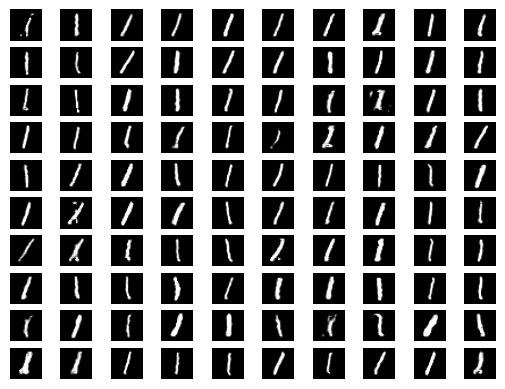

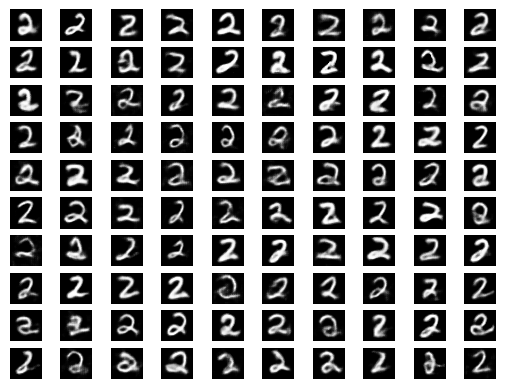

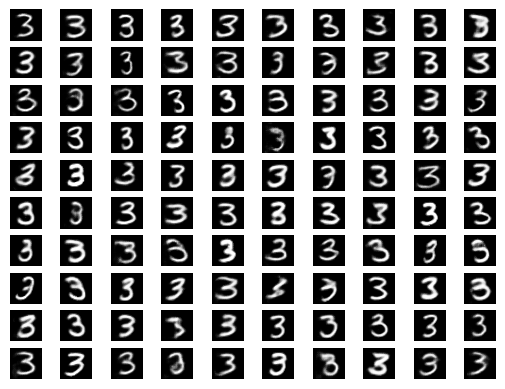

In [15]:
for s in space_recons:
    show(s)

In [16]:
irecons = trawl_image_latent_space(data, model, nvis=3, alpha=.01)

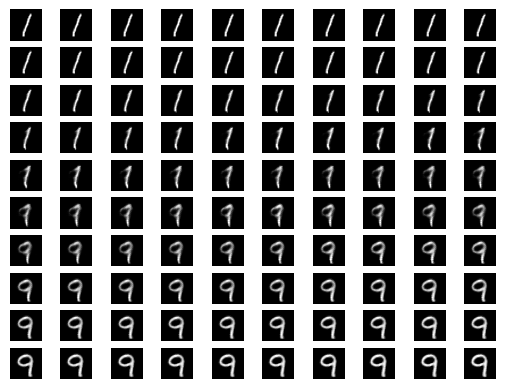

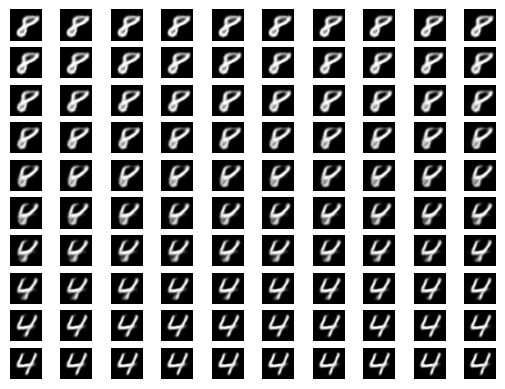

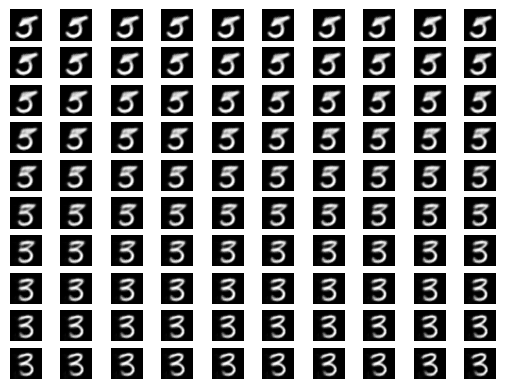

In [17]:
for i in irecons:
    show(i)

In [18]:
lrecons = explore_latent_space_meaning(model, 7, 100)

/tmp/ipykernel_17097/3089629268.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(n,n)


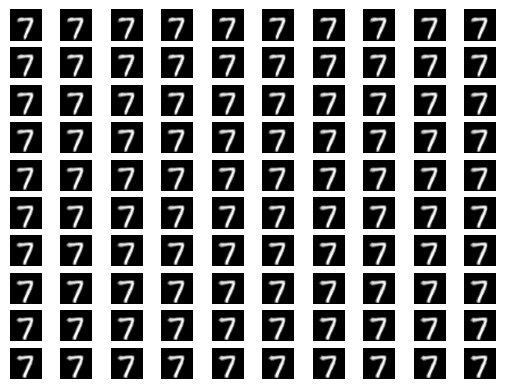

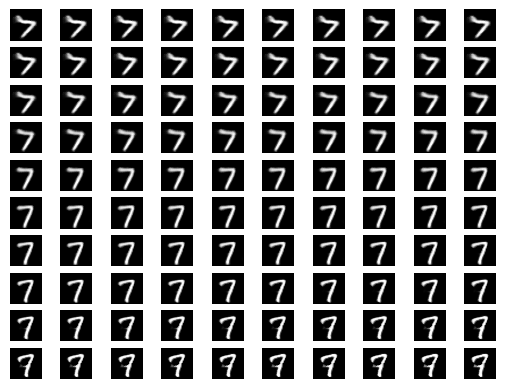

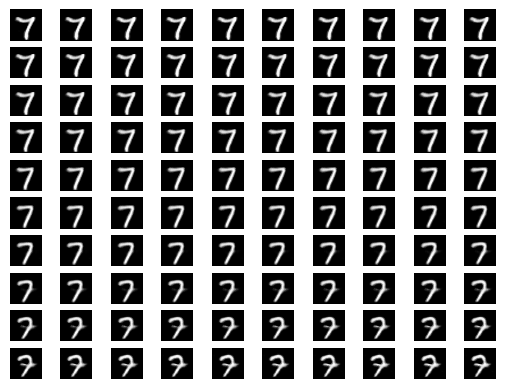

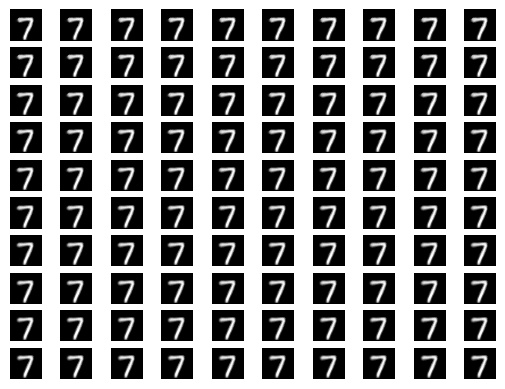

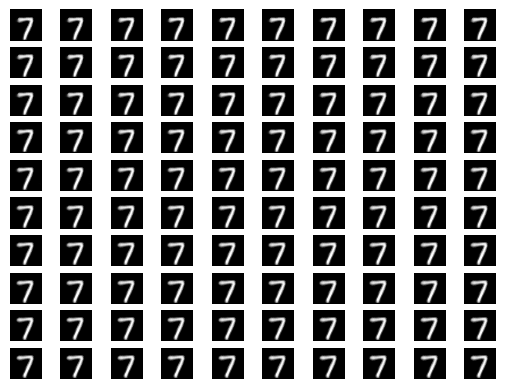

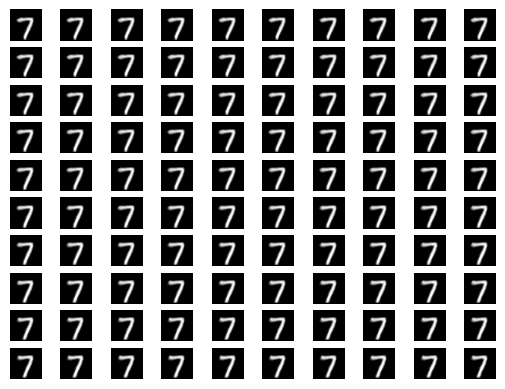

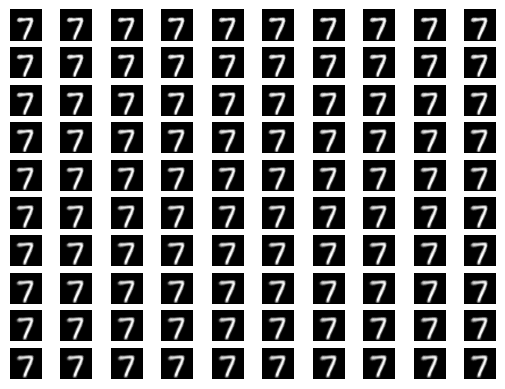

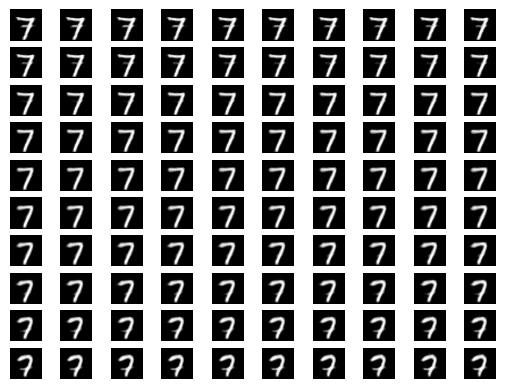

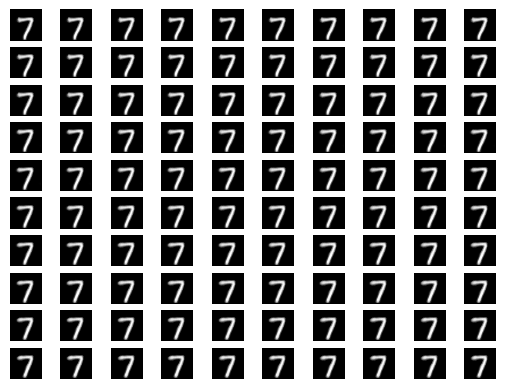

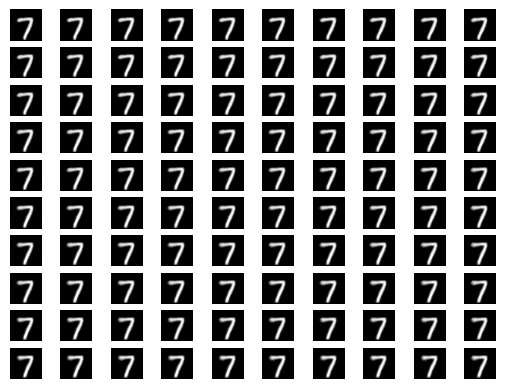

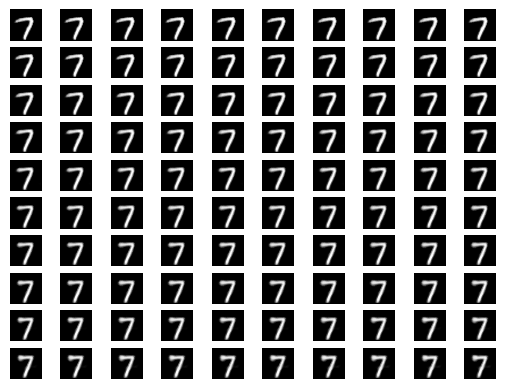

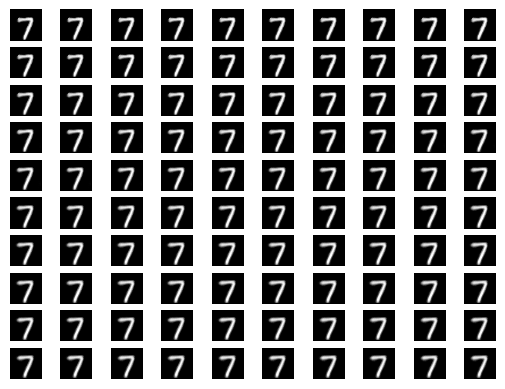

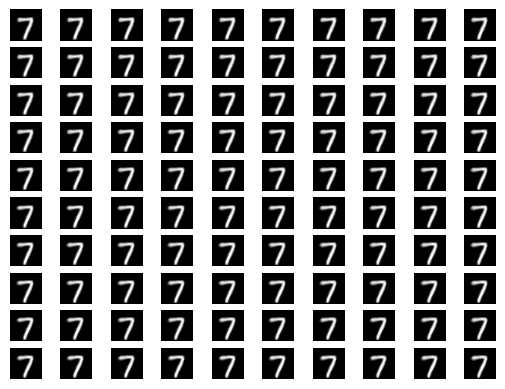

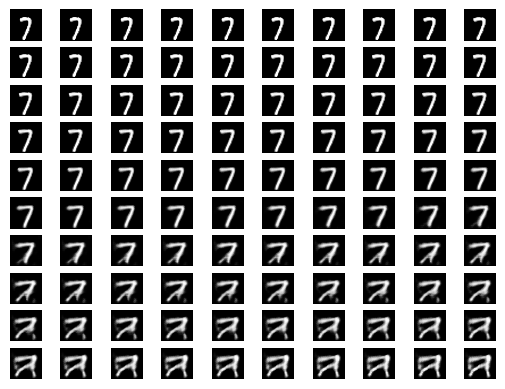

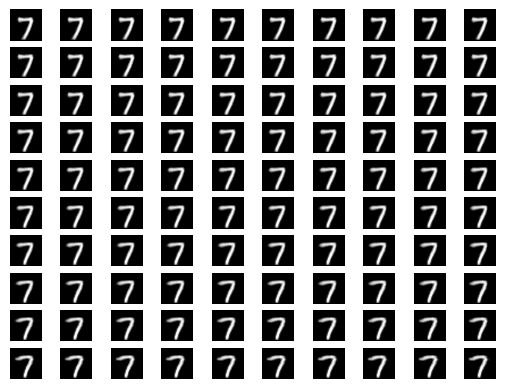

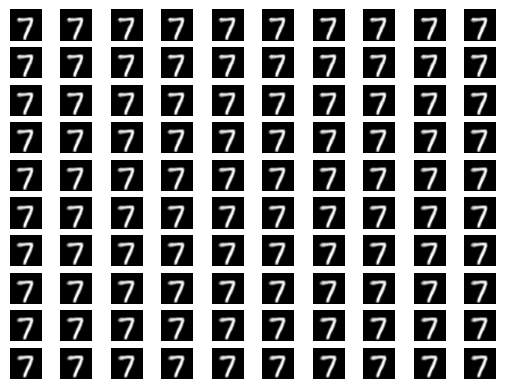

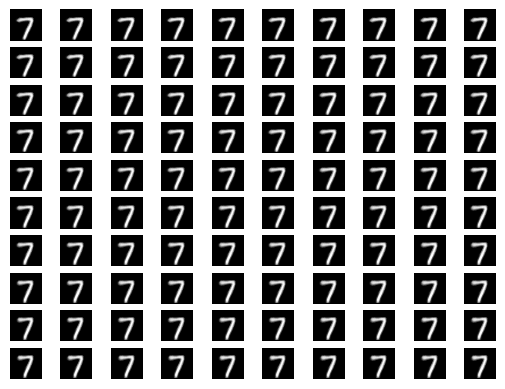

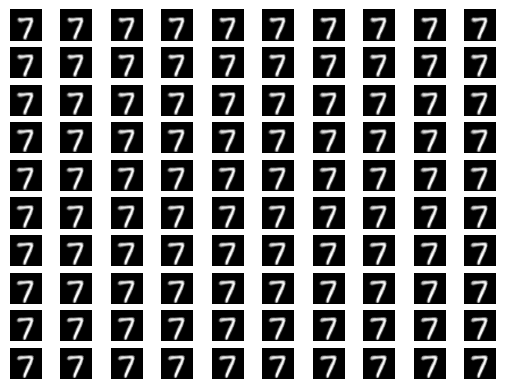

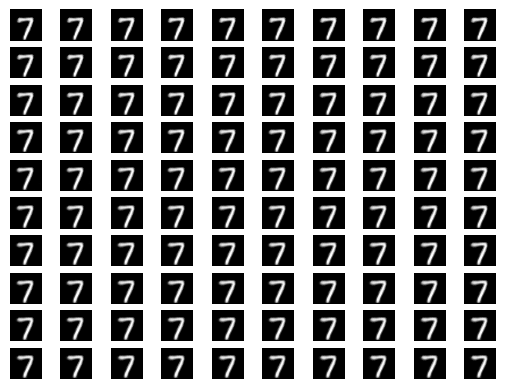

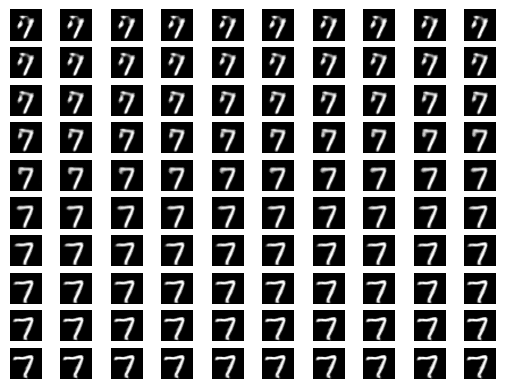

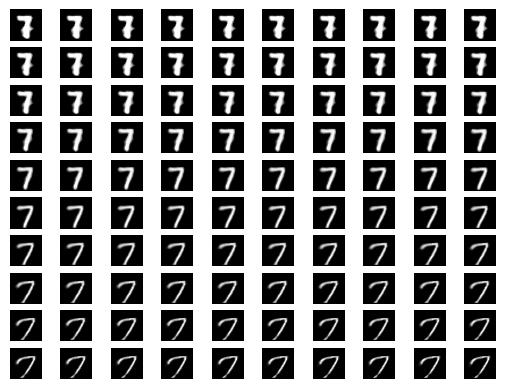

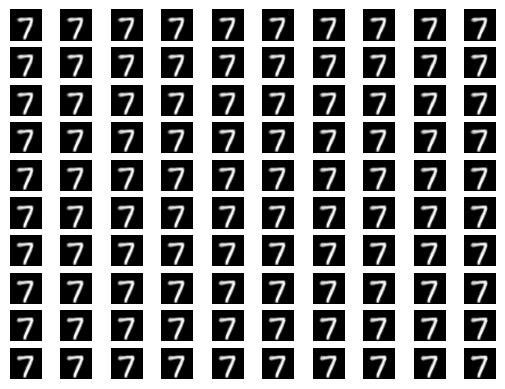

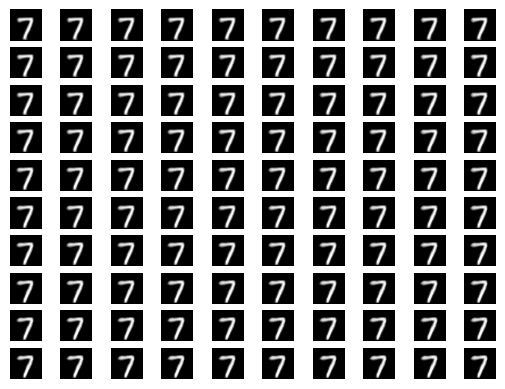

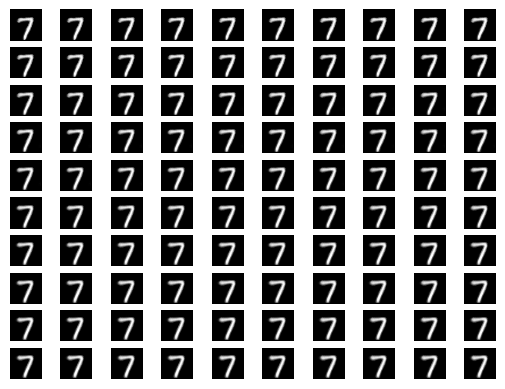

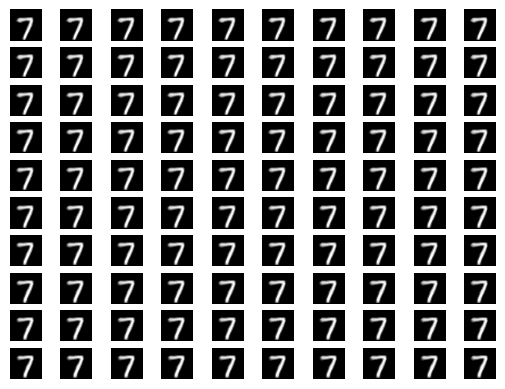

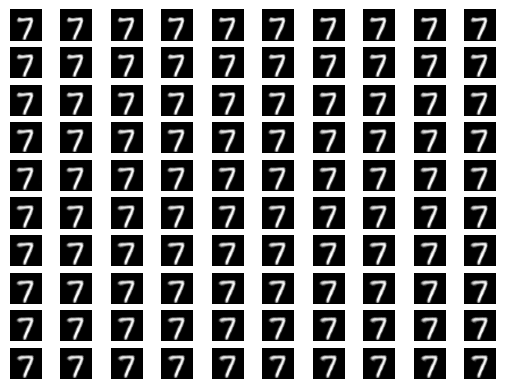

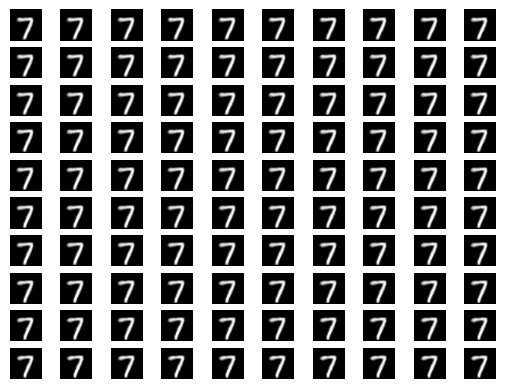

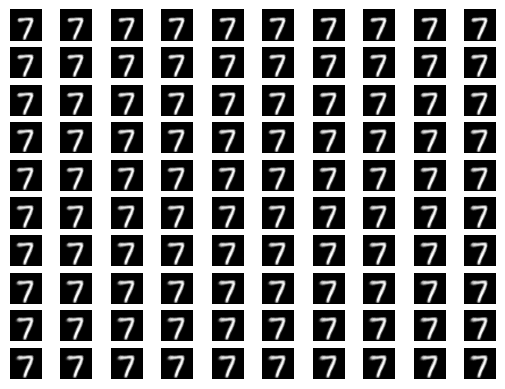

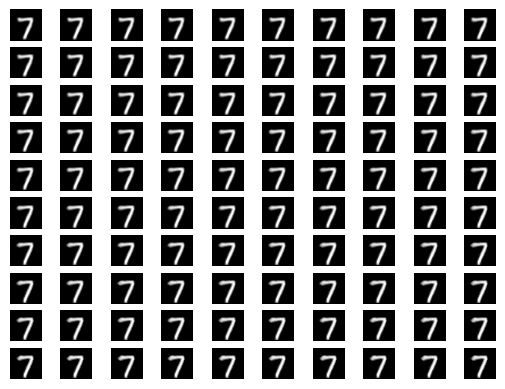

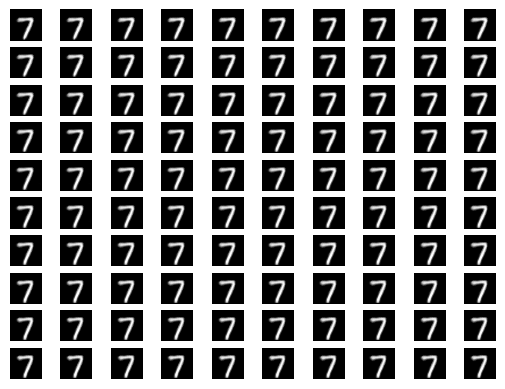

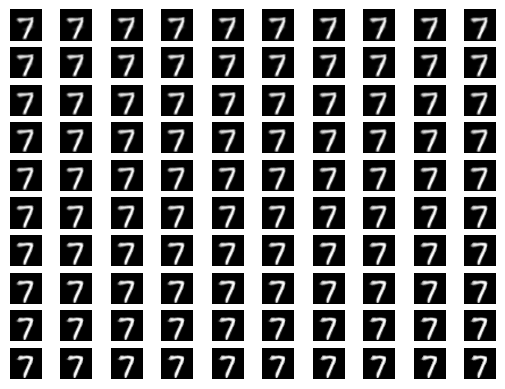

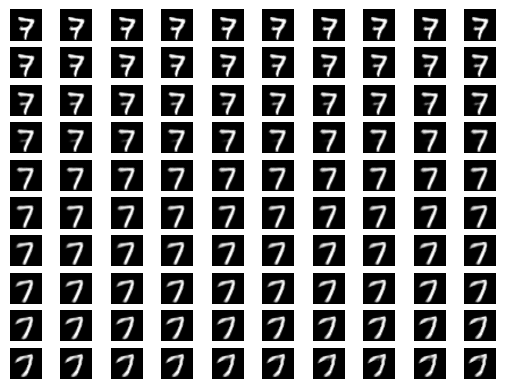

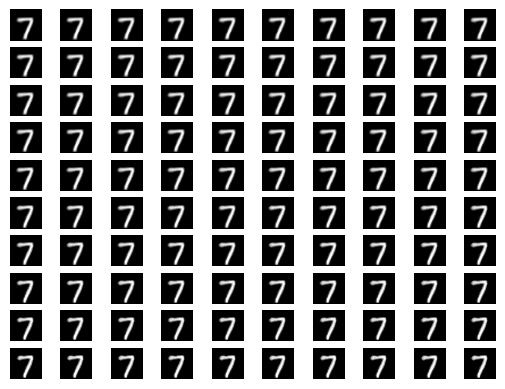

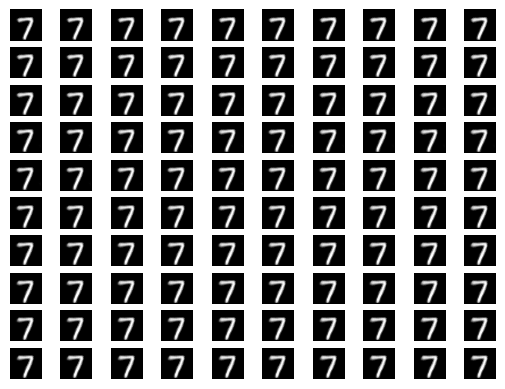

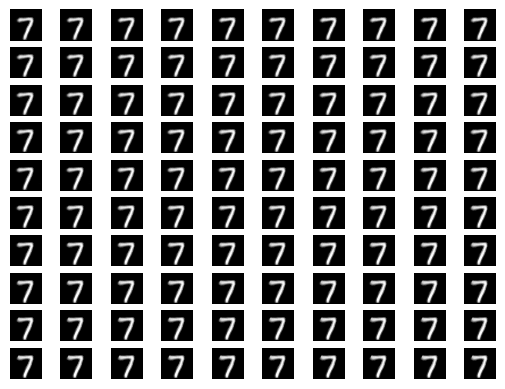

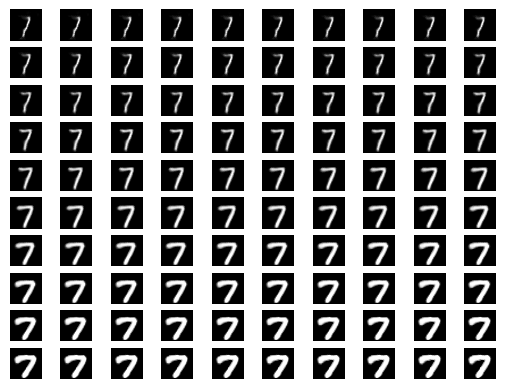

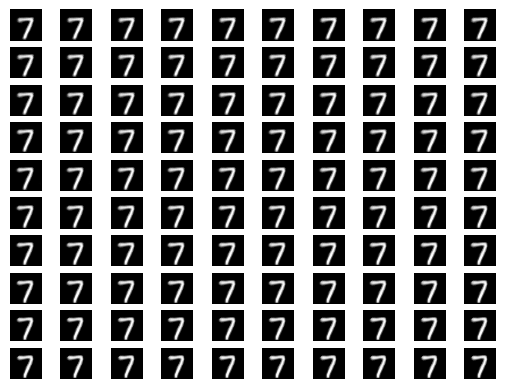

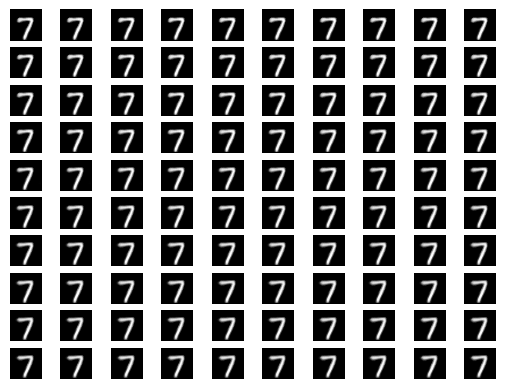

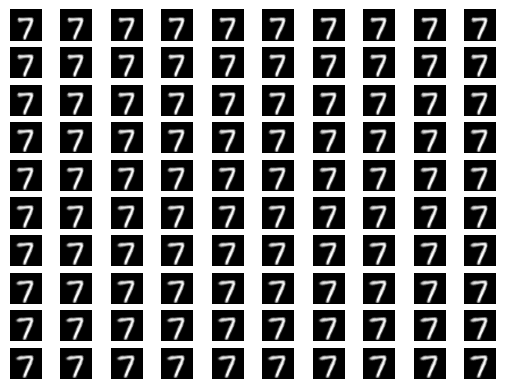

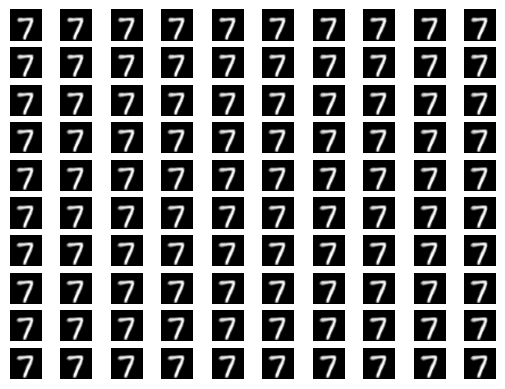

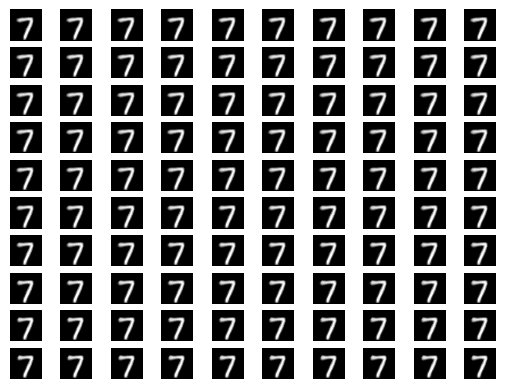

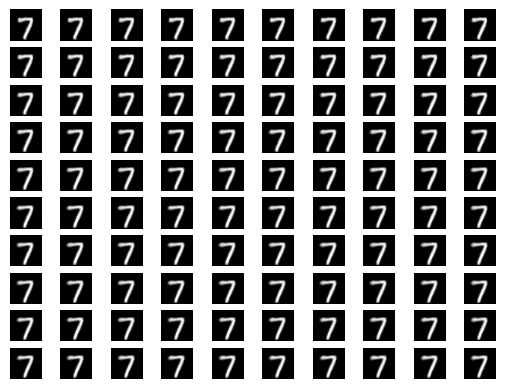

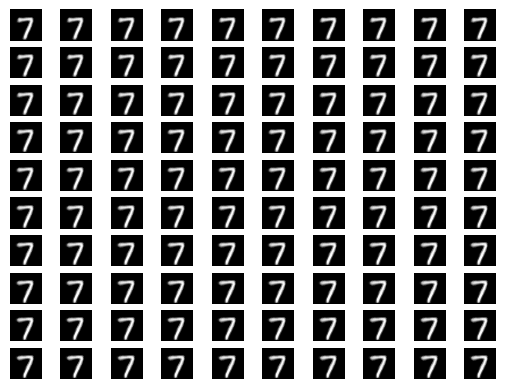

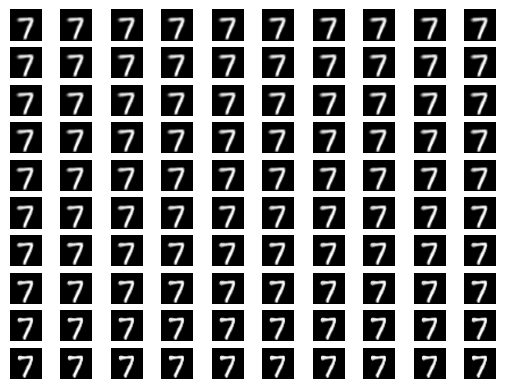

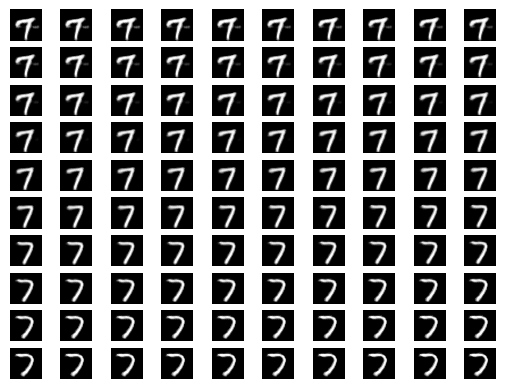

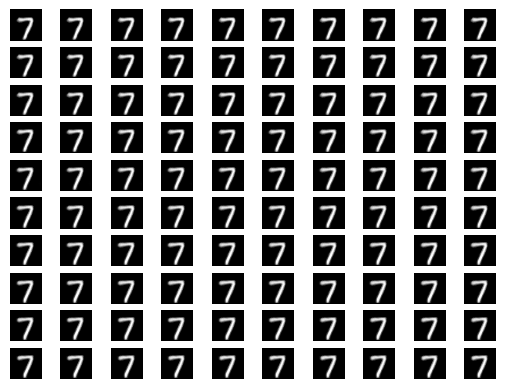

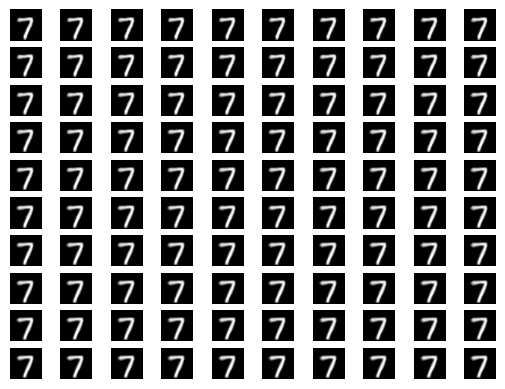

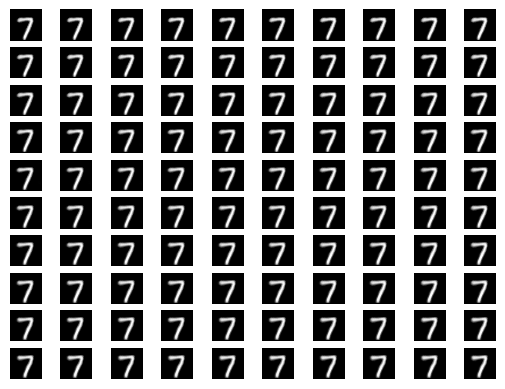

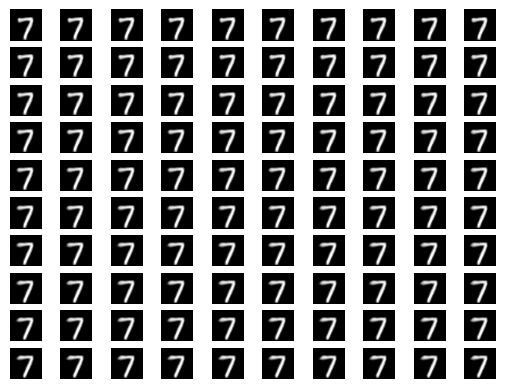

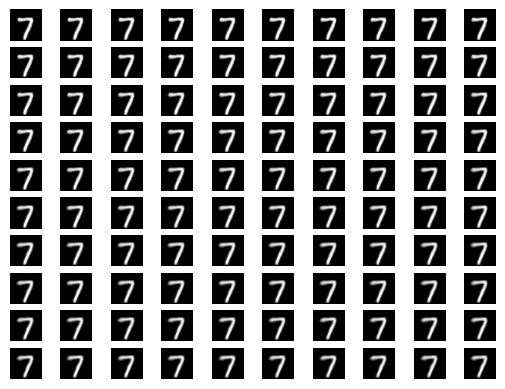

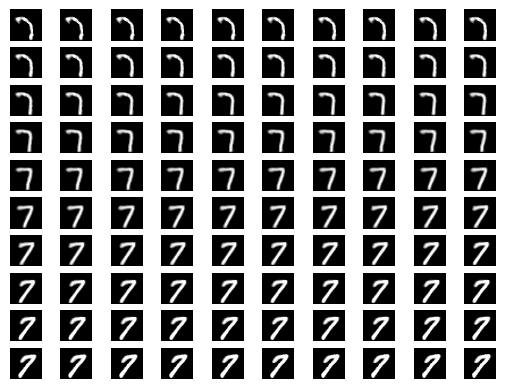

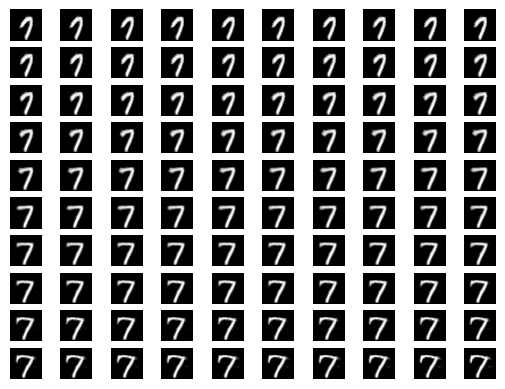

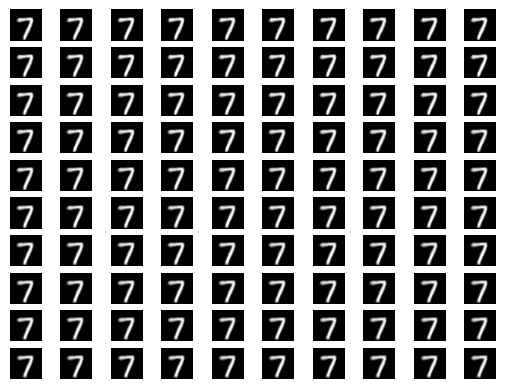

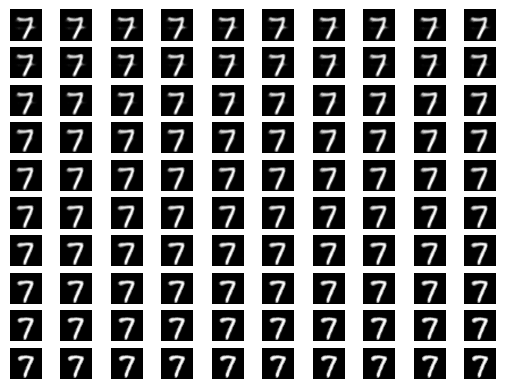

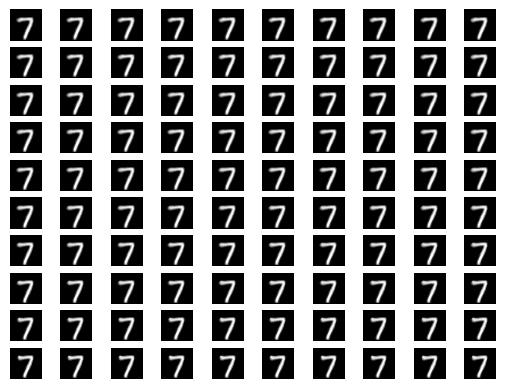

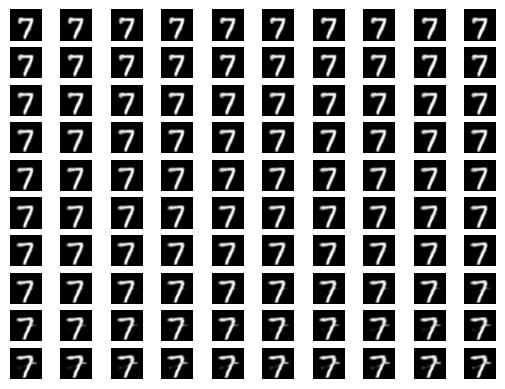

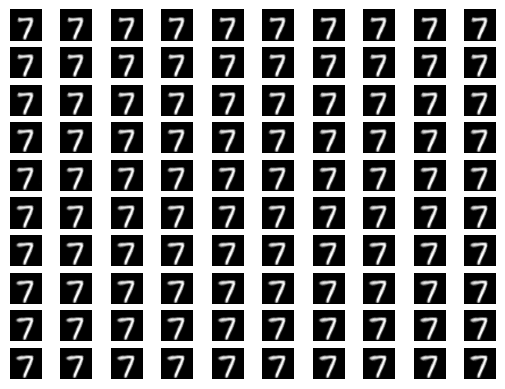

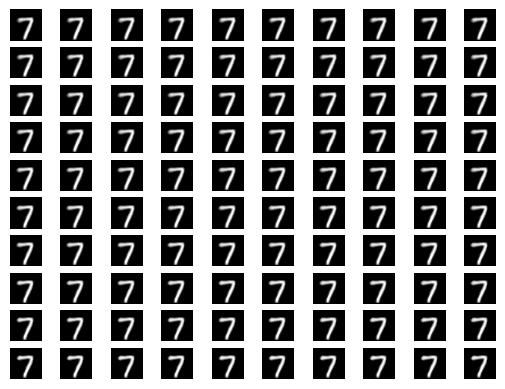

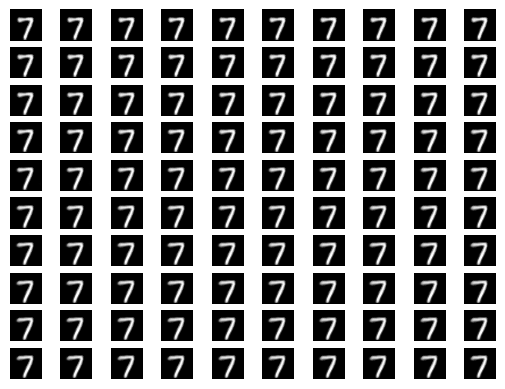

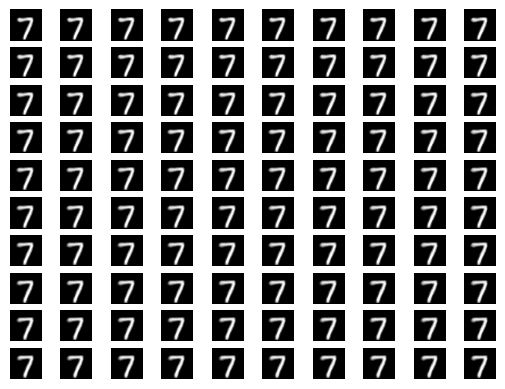

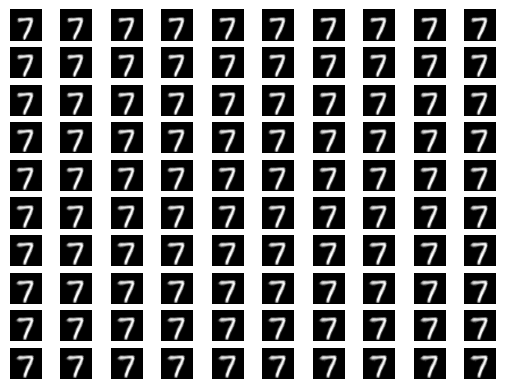

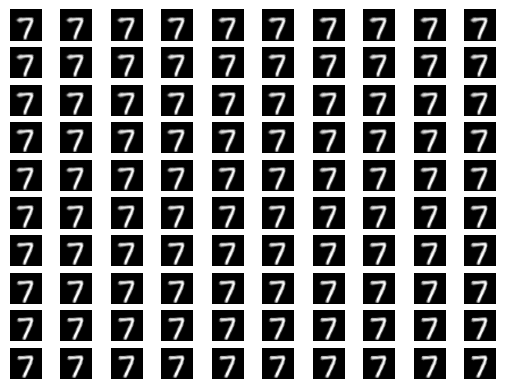

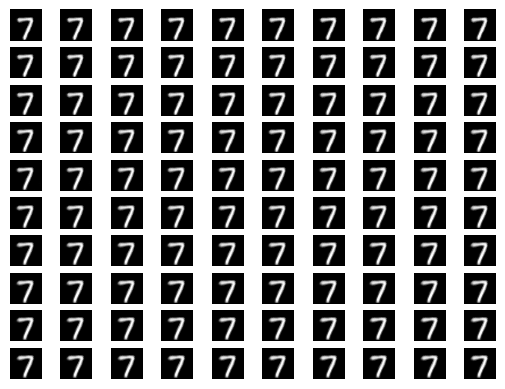

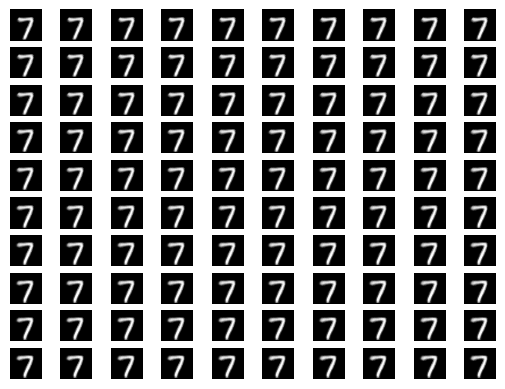

In [19]:
for lr in lrecons:
    show(lr)